In [ ]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Update and install Libraries
!pip install river
!pip install --upgrade scikit-learn

In [ ]:
# @title Import Libraries
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from river import forest

from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SecurityNetwork/final_dataset.csv', low_memory=False)

In [ ]:
df['family'].value_counts()

family
Trickbot      226436
Normal        171864
Dridex         92233
Miuref          4926
Zeus             964
Vawtrak          594
Hancitor         474
Gootkit          408
Dreambot         298
Zeus-panda        16
Name: count, dtype: int64

In [ ]:
balanced_df = pd.DataFrame(columns=df.columns)
for label in df['family'].unique():
    subset = df[df['family'] == label]
    if label=='Normal':
        if len(subset) > 100000:
          subset = subset.sample(100000)
    elif len(subset) > 15000:
        subset = subset.sample(15000)
    balanced_df = balanced_df._append(subset, ignore_index=True)
df = balanced_df
df.replace([np.nan], 0, inplace=True)

<ipython-input-10-23847a9f2e35>:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_df = balanced_df._append(subset, ignore_index=True)


In [ ]:
df

proto  service  duration  orig_bytes  resp_bytes  conn_state  history  \
0         0.0      1.0     180.0      2683.0      4474.0         5.0   1035.0   
1         0.0      1.0     483.0      2680.0      4474.0         5.0   1035.0   
2         0.0      1.0   19660.0     15545.0      4911.0         5.0   1035.0   
3         0.0      1.0  300704.0      2314.0      4474.0         5.0   1035.0   
4         0.0      1.0   15969.0     26010.0     25829.0         5.0   1123.0   
...       ...      ...       ...         ...         ...         ...      ...   
137675    0.0      1.0  191925.0       978.0      3050.0         5.0    488.0   
137676    0.0      1.0  259748.0       367.0      4875.0         5.0   1298.0   
137677    0.0      1.0  262328.0       359.0      3119.0         5.0    200.0   
137678    0.0      1.0  144749.0      1792.0      8501.0         5.0    334.0   
137679    0.0      1.0      28.0       988.0      4367.0         5.0   1035.0   

        missed_bytes  orig_pkts  resp_ip_bytes  ...  san_dns_num  san_ip_num  \
0                0.0        9.0         4806.0  ...        361.0         0.0   
1                0.0        9.0         4806.0  ...        361.0         0.0   
2                0.0       27.0         5763.0  ...        115.0         0.0   
3                0.0        9.0         4806.0  ...        361.0         0.0   
4                0.0       50.0        27761.0  ...         30.0         0.0   
...              ...        ...            ...  ...          ...         ...   
137675           0.0        9.0         3454.0  ...         29.0         0.0   
137676           0.0       13.0         5403.0  ...         45.0         0.0   
137677           0.0       11.0         3603.0  ...         33.0         0.0   
137678           0.0       27.0         9705.0  ...       2300.0         0.0   
137679           0.0       13.0         4947.0  ...         29.0         0.0   

        lets_encrypt  certificate.key_alg  certificate.sig_alg  \
0                1.0                  3.0                  5.0   
1                1.0                  3.0                  5.0   
2                1.0                  1.0                  1.0   
3                1.0                  3.0                  5.0   
4                1.0                  1.0                  1.0   
...              ...                  ...                  ...   
137675           1.0                  3.0                  5.0   
137676           1.0                  3.0                  5.0   
137677           1.0                  3.0                  5.0   
137678           1.0                  3.0                  5.0   
137679           1.0                  3.0                  5.0   

        certificate.key_type  certificate.key_length  basic_constraints.ca  \
0                        2.0                     3.0                   0.0   
1                        2.0                     3.0                   0.0   
2                        0.0                     5.0                   0.0   
3                        2.0                     3.0                   0.0   
4                        0.0                     5.0                   0.0   
...                      ...                     ...                   ...   
137675                   2.0                     2.0                   0.0   
137676                   2.0                     2.0                   0.0   
137677                   2.0                     2.0                   0.0   
137678                   2.0                     2.0                   0.0   
137679                   2.0                     2.0                   0.0   

        curve    family  
0         0.0  Hancitor  
1         0.0  Hancitor  
2         1.0  Hancitor  
3         0.0  Hancitor  
4         1.0  Hancitor  
...       ...       ...  
137675    0.0    Normal  
137676    0.0    Normal  
137677    0.0    Normal  
137678    0.0    Normal  
137679    0.0    Normal  

[137680 rows x 30 columns]

In [ ]:
df['family'].value_counts()

family
Normal        100000
Trickbot       15000
Dridex         15000
Miuref          4926
Zeus             964
Vawtrak          594
Hancitor         474
Gootkit          408
Dreambot         298
Zeus-panda        16
Name: count, dtype: int64

In [ ]:
#@title Label Encoding
le_atk = LabelEncoder()
df['family'] = le_atk.fit_transform(df['family'])

# Training and testing model

In [ ]:
#@title ConfusionMatrix()
def export_confusion_matrix(name, true_labels = None, predicted_labels = None, target_names = None):
  cm = confusion_matrix(true_labels, predicted_labels)
  cm_array = np.array(cm)
  accuracy = np.trace(cm) / np.sum(cm).astype('float')
  misclass = 1 - accuracy
  cmap = plt.get_cmap('Blues')
  norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100
  plt.figure(figsize=(21,8))
  plt.imshow(norm_cm, interpolation='nearest', cmap=cmap)
  plt.title(f'Normalized confusion matrix of {name}')
  plt.colorbar()
  tick_marks = np.arange(len(target_names))
  plt.xticks(tick_marks, target_names, rotation=45, fontsize='large')
  plt.yticks(tick_marks, target_names, fontsize='large')
  thresh= cm_array.max() / 2
  print("diem cao nhat", thresh)
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:,}\n{:0.2f}%".format(cm[i, j], norm_cm[i, j]),
            horizontalalignment="center",
            verticalalignment="center",
            color="white" if norm_cm[i, j] > 50 else "black")

  # print('Trace : ', np.trace(norm_cm)/8)
  plt.tight_layout()
  plt.ylabel('True label', fontsize='x-large')
  plt.xlabel('Predicted label', fontsize='x-large')
  # plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))

  plt.savefig('./report_cm_{0}.png'.format(name), bbox_inches='tight')
  plt.show()

In [ ]:
dict_predicts = {}
Res=[]
name_columns= ['Model', 'Accuracy', 'Precision', 'Recall', 'F1score', 'Training Time', 'Learning Samples']

---------------------Classification report for classifier IARF---------------------
              precision    recall  f1-score   support

    Dreambot       0.98      0.98      0.98       298
      Dridex       1.00      1.00      1.00     15000
     Gootkit       0.98      0.99      0.99       408
    Hancitor       1.00      1.00      1.00       474
      Miuref       1.00      1.00      1.00      4926
      Normal       1.00      1.00      1.00    100000
    Trickbot       1.00      1.00      1.00     15000
     Vawtrak       0.99      0.99      0.99       594
        Zeus       1.00      1.00      1.00       964
  Zeus-panda       0.72      0.81      0.76        16

    accuracy                           1.00    137680
   macro avg       0.97      0.98      0.97    137680
weighted avg       1.00      1.00      1.00    137680

diem cao nhat 49996.5


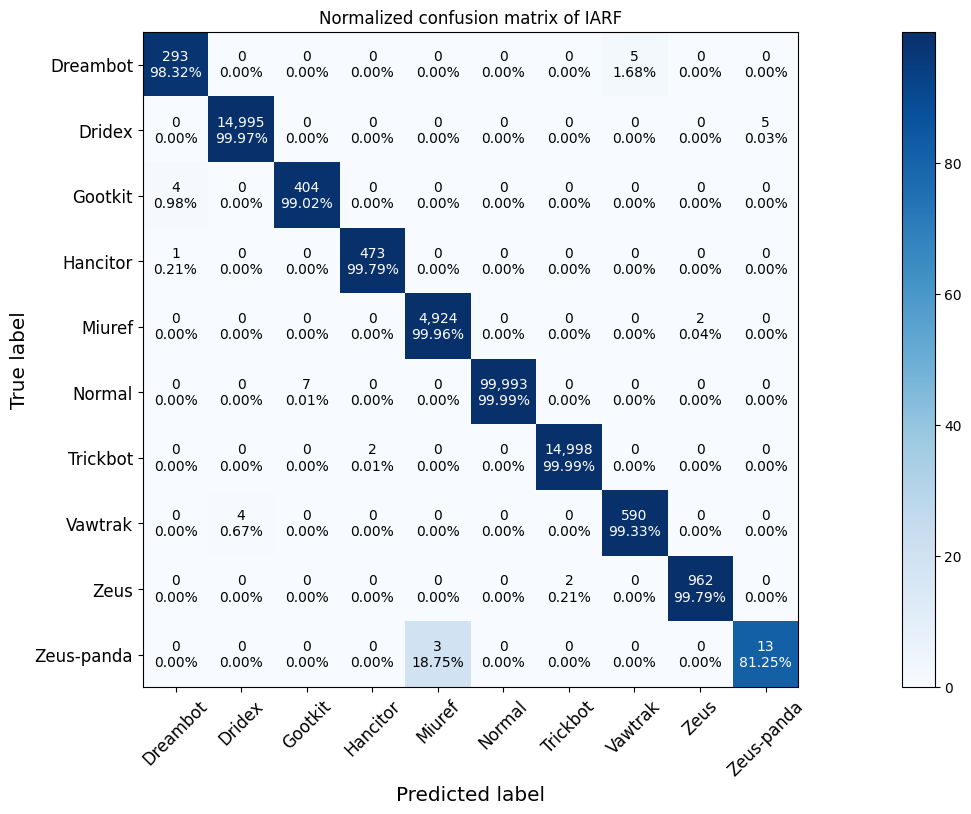

In [ ]:
#@title ImprovedAdaptiveRandomForestClassifier()

IARF = forest.ARFClassifier(n_models=10)
iarf_y_pred=[]
learning_samples=0

t_start = time.time()
for index, row in df.iterrows():
    x = row.drop('family')
    y = row['family']
    y_pred = IARF.predict_one(x)

    if y_pred==None:
      iarf_y_pred.append(0)
    else:
      iarf_y_pred.append(y_pred)

    # Improve than ARF
    if y != y_pred:
      IARF.learn_one(x, y)
      learning_samples+=1
t_train = time.time()-t_start

# Accuracy
accuracy = accuracy_score(df['family'].to_numpy(), iarf_y_pred)
# Precision
precision = precision_score(df['family'].to_numpy(), iarf_y_pred, average='micro')
# Recall
recall = recall_score(df['family'].to_numpy(), iarf_y_pred, average='micro')
# F1-score
f1 = f1_score(df['family'].to_numpy(), iarf_y_pred, average='micro')

Res.append(["IARF", accuracy, precision, recall, f1, t_train, learning_samples])
print(f"---------------------Classification report for classifier IARF---------------------")
print(classification_report(df['family'].to_numpy(), iarf_y_pred, target_names=le_atk.classes_))
export_confusion_matrix("IARF", true_labels = df['family'].to_numpy(), predicted_labels = iarf_y_pred, target_names=le_atk.classes_)

---------------------Classification report for classifier ARF---------------------
              precision    recall  f1-score   support

    Dreambot       0.99      0.95      0.97       298
      Dridex       1.00      1.00      1.00     15000
     Gootkit       0.98      1.00      0.99       408
    Hancitor       0.98      1.00      0.99       474
      Miuref       0.99      1.00      1.00      4926
      Normal       1.00      1.00      1.00    100000
    Trickbot       1.00      1.00      1.00     15000
     Vawtrak       0.98      0.94      0.96       594
        Zeus       0.98      0.95      0.96       964
  Zeus-panda       1.00      0.12      0.22        16

    accuracy                           1.00    137680
   macro avg       0.99      0.89      0.91    137680
weighted avg       1.00      1.00      1.00    137680

diem cao nhat 49994.5


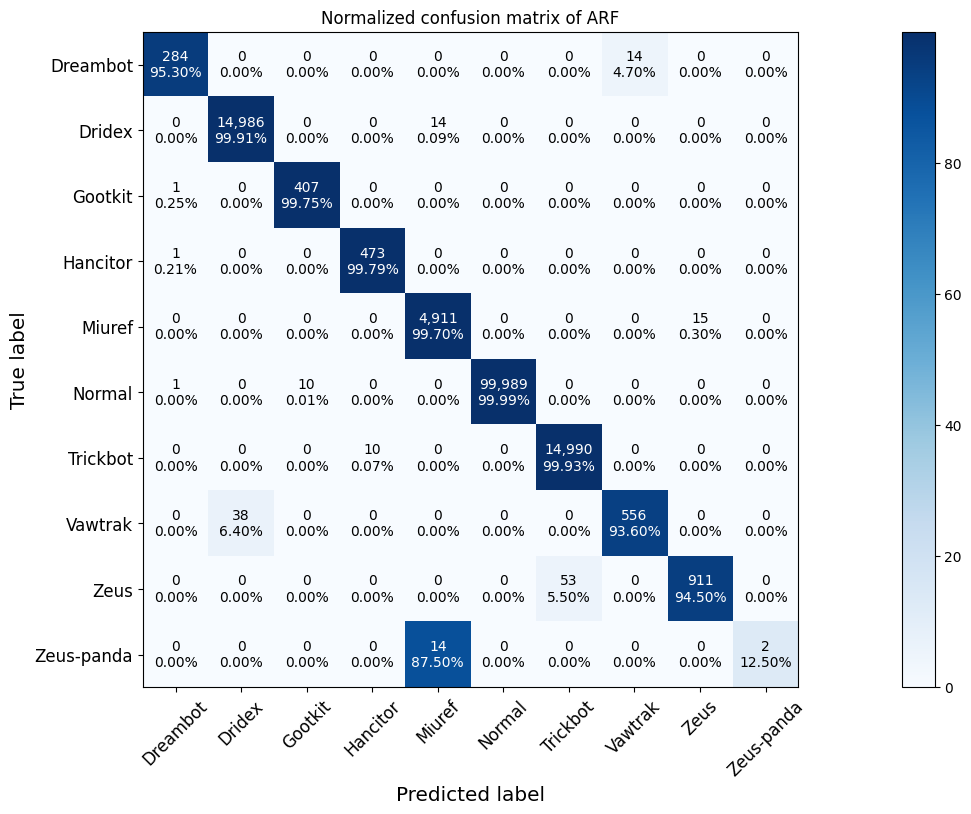

In [ ]:
#@title AdaptiveRandomForestClassifier()

ARF = forest.ARFClassifier(n_models=10)
arf_y_pred=[]

t_start = time.time()
for index, row in df.iterrows():
    x = row.drop('family')
    y = row['family']
    y_pred = ARF.predict_one(x)

    if y_pred==None:
      arf_y_pred.append(0)
    else:
      arf_y_pred.append(y_pred)

    ARF.learn_one(x, y)
t_train = time.time()-t_start

# Accuracy
accuracy = accuracy_score(df['family'].to_numpy(), arf_y_pred)
# Precision
precision = precision_score(df['family'].to_numpy(), arf_y_pred, average='micro')
# Recall
recall = recall_score(df['family'].to_numpy(), arf_y_pred, average='micro')
# F1-score
f1 = f1_score(df['family'].to_numpy(), arf_y_pred, average='micro')

Res.append(["ARF", accuracy, precision, recall, f1, t_train, len(df)])
print(f"---------------------Classification report for classifier ARF---------------------")
print(classification_report(df['family'].to_numpy(), arf_y_pred, target_names=le_atk.classes_))
export_confusion_matrix("ARF", true_labels = df['family'].to_numpy(), predicted_labels = arf_y_pred, target_names=le_atk.classes_)

In [ ]:
#@title TrainTestSplit
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['family']).to_numpy(), df['family'].to_numpy(), test_size=0.3, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

---------------------Classification report for classifier LRCV---------------------
              precision    recall  f1-score   support

    Dreambot       0.00      0.00      0.00        87
      Dridex       0.90      0.24      0.38      4565
     Gootkit       0.00      0.00      0.00       129
    Hancitor       0.00      0.00      0.00       146
      Miuref       0.00      0.00      0.00      1468
      Normal       0.75      1.00      0.86     29944
    Trickbot       0.00      0.00      0.00      4478
     Vawtrak       0.00      0.00      0.00       182
        Zeus       0.93      0.65      0.77       299
  Zeus-panda       0.00      0.00      0.00         6

    accuracy                           0.75     41304
   macro avg       0.26      0.19      0.20     41304
weighted avg       0.65      0.75      0.67     41304

diem cao nhat 14919.0


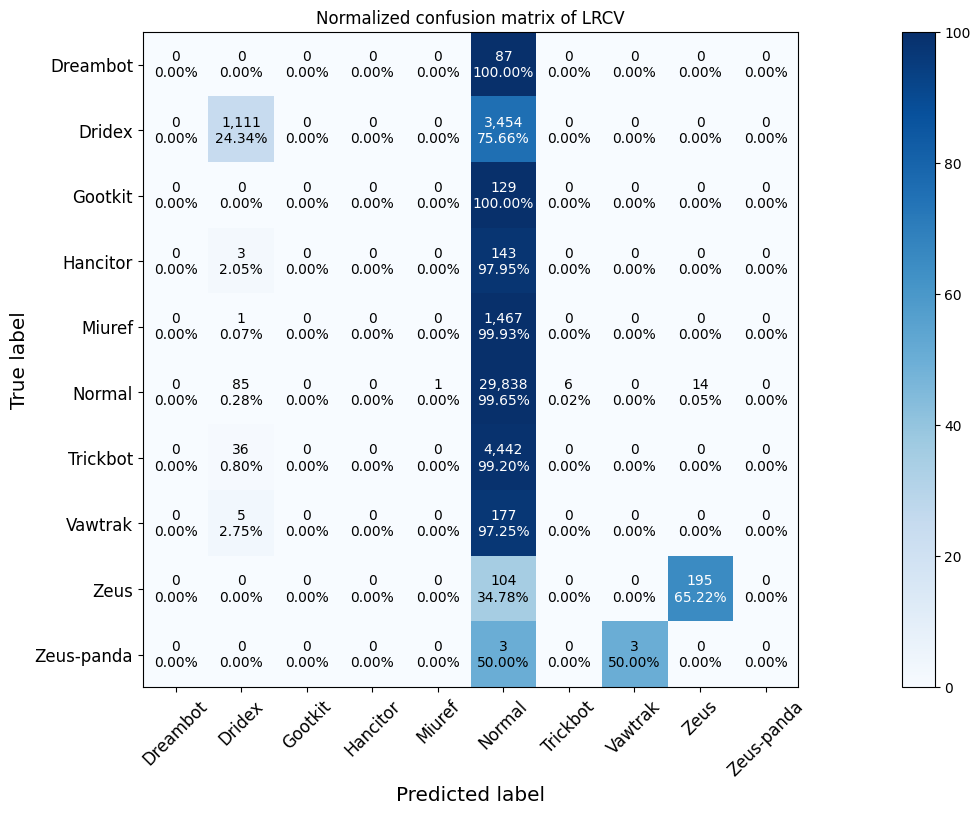

In [ ]:
#@title LogisticRegressionCV()
LRCV=LogisticRegressionCV()
t_start=time.time()
LRCV.fit(X_train, y_train)
t_train=time.time()-t_start
# Predict
lrcv_y_pred=LRCV.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, lrcv_y_pred)
# Precision
precision = precision_score(y_test, lrcv_y_pred, average='micro')
# Recall
recall = recall_score(y_test, lrcv_y_pred, average='micro')
# F1-score
f1 = f1_score(y_test, lrcv_y_pred, average='micro')

Res.append(["LRCV", accuracy, precision, recall, f1, t_train, len(X_train)])
print(f"---------------------Classification report for classifier LRCV---------------------")
print(classification_report(y_test, lrcv_y_pred, target_names=le_atk.classes_))
export_confusion_matrix("LRCV", true_labels = y_test, predicted_labels = lrcv_y_pred, target_names=le_atk.classes_)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

---------------------Classification report for classifier LSVC---------------------
              precision    recall  f1-score   support

    Dreambot       0.00      0.00      0.00        87
      Dridex       0.79      0.82      0.80      4565
     Gootkit       0.00      0.00      0.00       129
    Hancitor       0.00      0.00      0.00       146
      Miuref       0.27      0.23      0.25      1468
      Normal       0.95      0.96      0.96     29944
    Trickbot       0.83      0.91      0.87      4478
     Vawtrak       1.00      0.01      0.01       182
        Zeus       0.87      0.56      0.68       299
  Zeus-panda       0.00      0.00      0.00         6

    accuracy                           0.89     41304
   macro avg       0.47      0.35      0.36     41304
weighted avg       0.89      0.89      0.89     41304

diem cao nhat 14320.5


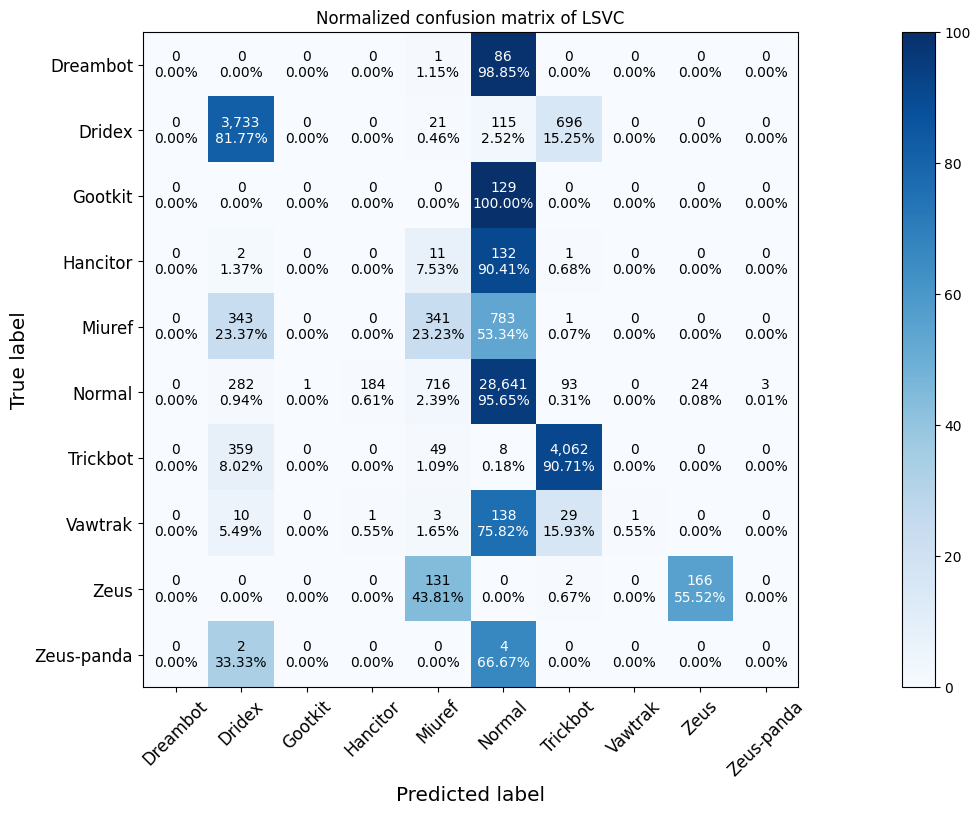

In [ ]:
#@title LinearSVC()
LSVC=LinearSVC()
t_start=time.time()
LSVC.fit(X_train, y_train)
t_train=time.time()-t_start
# Predict
lsvc_y_pred=LSVC.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, lsvc_y_pred)
# Precision
precision = precision_score(y_test, lsvc_y_pred, average='micro')
# Recall
recall = recall_score(y_test, lsvc_y_pred, average='micro')
# F1-score
f1 = f1_score(y_test, lsvc_y_pred, average='micro')

Res.append(["LSVC", accuracy, precision, recall, f1, t_train, len(X_train)])
print(f"---------------------Classification report for classifier LSVC---------------------")
print(classification_report(y_test, lsvc_y_pred, target_names=le_atk.classes_))
export_confusion_matrix("LSVC", true_labels = y_test, predicted_labels = lsvc_y_pred, target_names=le_atk.classes_)

---------------------Classification report for classifier RForest---------------------
              precision    recall  f1-score   support

    Dreambot       1.00      1.00      1.00        87
      Dridex       1.00      1.00      1.00      4565
     Gootkit       1.00      1.00      1.00       129
    Hancitor       1.00      0.99      1.00       146
      Miuref       1.00      1.00      1.00      1468
      Normal       1.00      1.00      1.00     29944
    Trickbot       1.00      1.00      1.00      4478
     Vawtrak       1.00      0.86      0.93       182
        Zeus       1.00      1.00      1.00       299
  Zeus-panda       1.00      1.00      1.00         6

    accuracy                           1.00     41304
   macro avg       1.00      0.99      0.99     41304
weighted avg       1.00      1.00      1.00     41304

diem cao nhat 14972.0


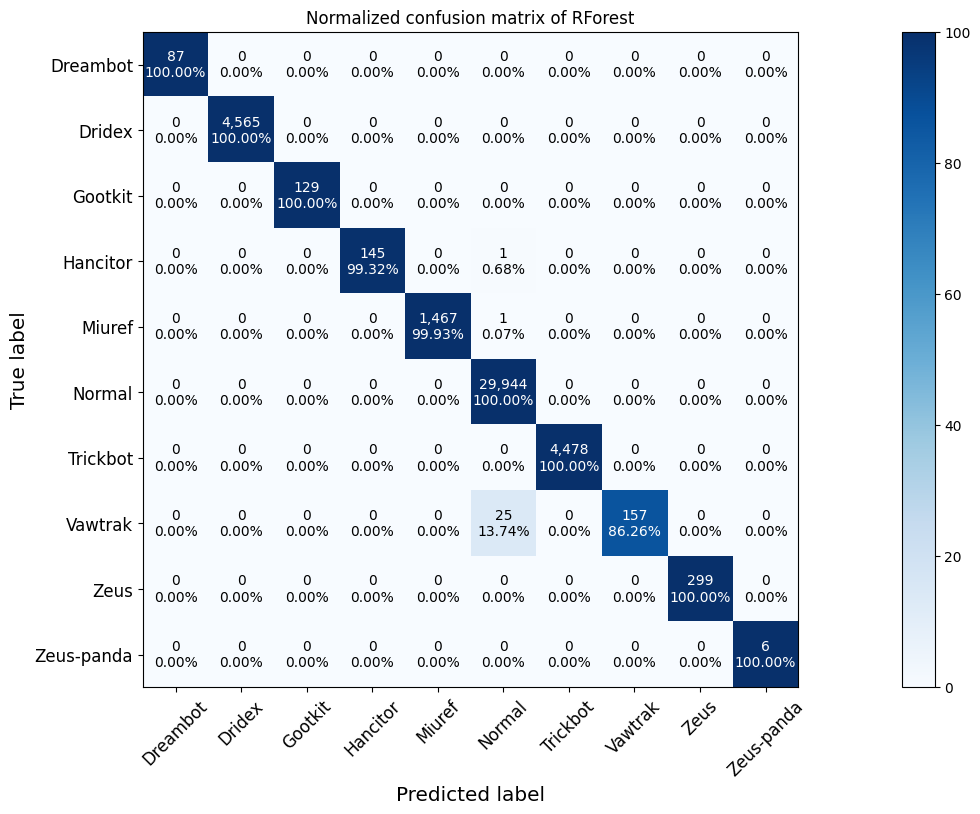

In [ ]:
#@title RandomForestClassifier()
  # Training
RForest=RandomForestClassifier()
t_start=time.time()
RForest.fit(X_train, y_train)
t_train=time.time()-t_start
# Predict
rf_y_pred=RForest.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, rf_y_pred)
# Precision
precision = precision_score(y_test, rf_y_pred, average='micro')
# Recall
recall = recall_score(y_test, rf_y_pred, average='micro')
# F1-score
f1 = f1_score(y_test, rf_y_pred, average='micro')

Res.append(["RForest", accuracy, precision, recall, f1, t_train, len(X_train)])
print(f"---------------------Classification report for classifier RForest---------------------")
print(classification_report(y_test, rf_y_pred, target_names=le_atk.classes_))
export_confusion_matrix("RForest", true_labels = y_test, predicted_labels = rf_y_pred, target_names=le_atk.classes_)

---------------------Classification report for classifier GBDT---------------------
              precision    recall  f1-score   support

    Dreambot       1.00      1.00      1.00        87
      Dridex       1.00      1.00      1.00      4565
     Gootkit       1.00      1.00      1.00       129
    Hancitor       1.00      1.00      1.00       146
      Miuref       1.00      1.00      1.00      1468
      Normal       1.00      1.00      1.00     29944
    Trickbot       1.00      1.00      1.00      4478
     Vawtrak       0.99      0.87      0.93       182
        Zeus       1.00      1.00      1.00       299
  Zeus-panda       1.00      0.83      0.91         6

    accuracy                           1.00     41304
   macro avg       1.00      0.97      0.98     41304
weighted avg       1.00      1.00      1.00     41304

diem cao nhat 14971.0


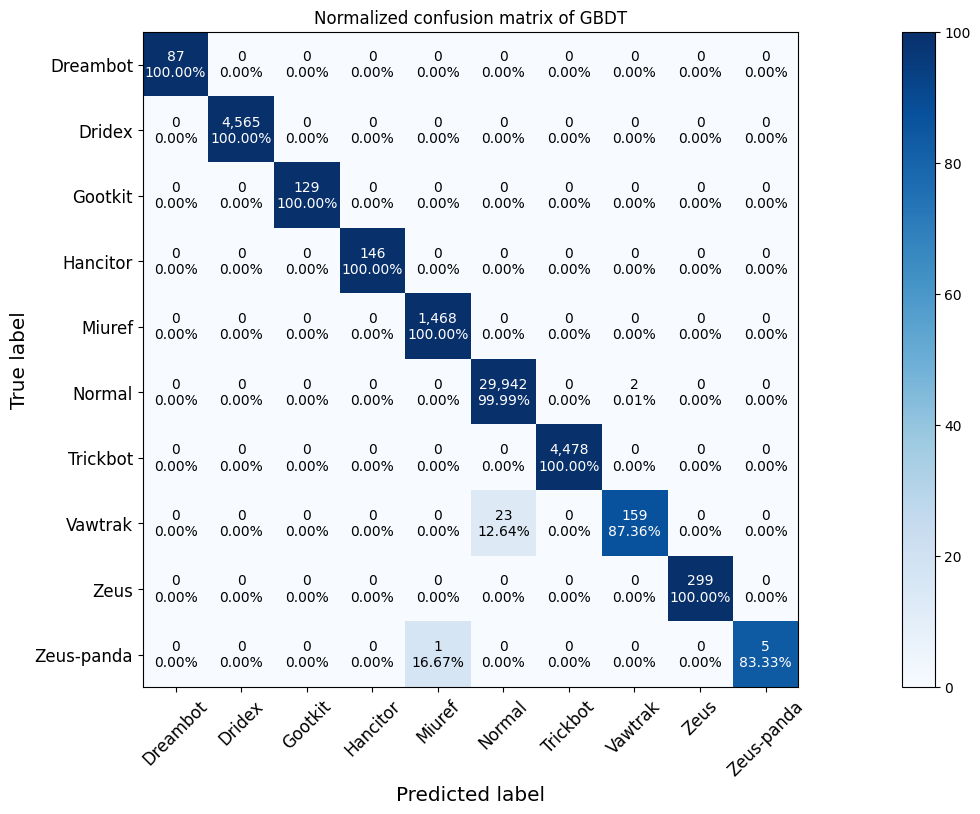

In [ ]:
#@title GradientBoostingClassifier()

# Training
GBDT=GradientBoostingClassifier()
t_start=time.time()
GBDT.fit(X_train, y_train)
t_train=time.time()-t_start
# Predict
gbdt_y_pred=GBDT.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, gbdt_y_pred)
# Precision
precision = precision_score(y_test, gbdt_y_pred, average='micro')
# Recall
recall = recall_score(y_test, gbdt_y_pred, average='micro')
# F1-score
f1 = f1_score(y_test, gbdt_y_pred, average='micro')

Res.append(["GBDT", accuracy, precision, recall, f1, t_train, len(X_train)])
print(f"---------------------Classification report for classifier GBDT---------------------")
print(classification_report(y_test, gbdt_y_pred, target_names=le_atk.classes_))
export_confusion_matrix("GBDT", true_labels = y_test, predicted_labels = gbdt_y_pred, target_names=le_atk.classes_)

In [ ]:
#@title Export results
df_report = pd.DataFrame(Res, columns = name_columns)
df_report.to_csv('./report_models.csv')
df_report

Model  Accuracy  Precision    Recall   F1score  Training Time  \
0     IARF  0.999746   0.999746  0.999746  0.999746     167.751080   
1      ARF  0.998758   0.998758  0.998758  0.998758     450.369688   
2     LRCV  0.754019   0.754019  0.754019  0.754019     359.939483   
3     LSVC  0.894441   0.894441  0.894441  0.894441     221.585587   
4  RForest  0.999346   0.999346  0.999346  0.999346      13.950649   
5     GBDT  0.999371   0.999371  0.999371  0.999371     345.723974   

   Learning Samples  
0                35  
1            137680  
2             96376  
3             96376  
4             96376  
5             96376